# Эквивалентность моделей вход-выход, моделей в пространстве состояний и авторегрессионных моделей ВР 

In [1]:
import numpy as np
from scipy.signal import dlti, dlsim, unit_impulse
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math
import statsmodels.api as sm

from linear_dynamics import LinearDynamicalSystem as LDS
np.set_printoptions(precision=2)

In [2]:
def bmatrix(a: np.ndarray, name: str) -> str:
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(np.round(a, 3)).replace('[', '').replace(']', '').splitlines()
    rv = [name + r' = \begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

def plot_signal(sig: np.ndarray, filtered: np.array) -> None:
    """Visualize system response

    :sig: numpy array, input signal
    :filtered: numpy array, system response
    """
    fig, (ax_orig, ax_filt) = plt.subplots(2, 1, sharex=True)
    ax_orig.plot(sig)
    ax_orig.set_title('Original pulse')
    ax_orig.margins(0, 0.1)
    ax_filt.plot(filtered)
    ax_filt.set_title('Filtered signal')
    ax_filt.margins(0, 0.1)
    fig.tight_layout()
    plt.show()

## Задаем параметры жордановой клетки и количества наблюдений 

In [ ]:
N_REAL = 6
N_COMPLEX = 2
T_OBS = 100

In [27]:
lds = LDS(N_REAL, N_COMPLEX)
sig = unit_impulse(T_OBS)

In [18]:
display(Math(bmatrix(np.array(lds.f_s), r'f^s')))
display(Math(bmatrix(np.array(lds.f_c), r'f^c')))
display(Math(bmatrix(np.array(lds.ro), r'\rho')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Запуск симуляции 

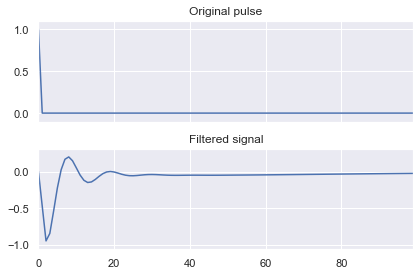

In [28]:
%matplotlib inline
sns.set()
plot_signal(sig, lds.simulate(T_OBS, sig))

## Переход к пространству состояний 

In [30]:
system = dlti(*lds.get_statespace(), dt=1)

C:\Users\andro\Documents\Python Scripts\linear_dynamics\linear_dynamics.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


In [31]:
_, y, _ = dlsim(system, sig)

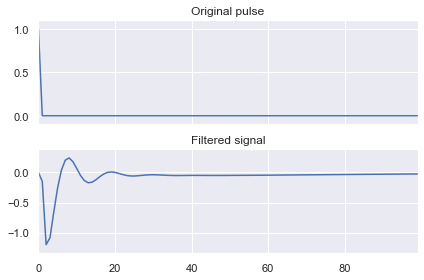

In [32]:
%matplotlib inline
plot_signal(sig, y.T.ravel())

## Переход к модели авторегрессии

In [34]:
arma_process = sm.tsa.ArmaProcess(*lds.get_arma())

C:\Users\andro\Documents\Python Scripts\linear_dynamics\linear_dynamics.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  A[:, -1] = np.array(ai[::-1]).T


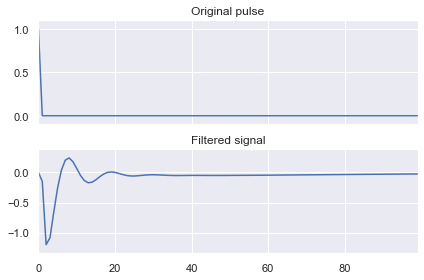

In [36]:
%matplotlib inline
plot_signal(sig, arma_process.impulse_response(T_OBS))

## Вывод: визуально очевидна эквивалентность всех трёх форм представления системы 